##### Get a boundary of data to read from, to match OSM region data

In [1]:
import pyrosm

/mnt/c/Users/Alfred/CLionProjects/outbreak-sim/python/venv/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Get London's OpenStreetMap data
fp = pyrosm.get_data("London", update=True)
print(fp)
# Initialize the OSM object 
osm = pyrosm.OSM(fp)

Downloaded Protobuf data 'London.osm.pbf' (66.79 MB) to:
'/tmp/pyrosm/London.osm.pbf'
/tmp/pyrosm/London.osm.pbf


<AxesSubplot:>

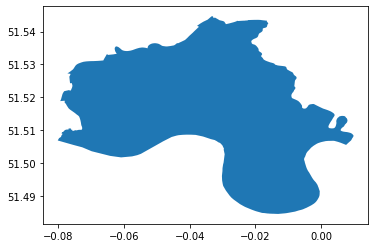

In [34]:
# Read all boundaries using the default settings
boundaries = osm.get_boundaries()

# pick a small subset for testing
boundary = osm.get_boundaries(name="London Borough of Tower Hamlets")
boundary.plot()

##### Load WorldPop Dataset and transform to match boundary

In [28]:
import geopandas as gpd
import rasterio
import rioxarray as rxr
from matplotlib import pyplot as plt

In [33]:
uk_wp = rxr.open_rasterio('./data/gbr_ppp_2020_UNadj_constrained.tif', masked=True).squeeze()
uk_wp.rio.crs  # make sure the crs is EPSG:4326 (WGS84) to match the unprojected OSM boundary

CRS.from_epsg(4326)

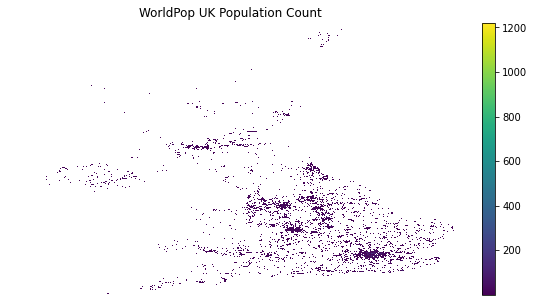

In [30]:
f, ax = plt.subplots(figsize=(10, 5))
uk_wp.plot.imshow()
ax.set(title="WorldPop UK Population Count")

ax.set_axis_off()
plt.show()

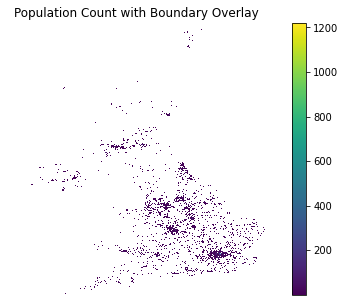

In [35]:
f, ax = plt.subplots(figsize=(10, 5))
uk_wp.plot.imshow(ax=ax)

boundary.plot(ax=ax, alpha=.8)
ax.set(title="Population Count with Boundary Overlay")

ax.set_axis_off()
plt.show()

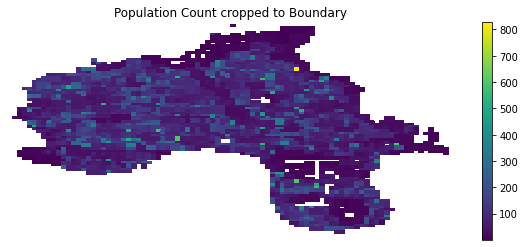

In [90]:
from shapely.geometry import mapping
from rasterio.crs import CRS

wp_clipped = uk_wp.rio.clip(boundary.geometry.apply(mapping))
wp_clipped = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700))

f, ax = plt.subplots(figsize=(10, 4))
wp_clipped.plot(ax=ax)
ax.set(title="Population Count cropped to Boundary")
ax.set_axis_off()
plt.show()

In [91]:
wp_clipped.sum()

<xarray.DataArray ()>
array(350617.35976988)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

In [47]:
# wp_clipped.rio.to_raster('./data/tower_hamlets_wp.tif')

In [71]:
out_array = np.array(wp_clipped.data)

In [72]:
out_array[np.isnan(out_array)] = 0  # replace nan's with -1
out_array = out_array.astype(int)

In [75]:
np.savetxt('./data/tower_hamlets_wp.txt', out_array, fmt='%d')

In [86]:
wp_clipped

<xarray.DataArray (y: 72, x: 107)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 51.54 51.54 51.54 51.54 ... 51.49 51.49 51.49 51.48
  * x            (x) float64 -0.07917 -0.07833 -0.0775 ... 0.008333 0.009167
    band         int64 1
    spatial_ref  int64 0
Attributes:
    STATISTICS_MAXIMUM:  1220.0987548828
    STATISTICS_MEAN:     15.745517550165
    STATISTICS_MINIMUM:  0.0054055140353739
    STATISTICS_STDDEV:   19.252242510081
    scale_factor:        1.0
    add_offset:          0.0
    grid_mapping:        spatial_ref